In [1]:
import os

import random
from datetime import datetime
from typing import Dict, Tuple, Any
import pickle
from tqdm import tqdm

import math

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import cv2
import albumentations
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Dataset

import timm

import matplotlib.pyplot as plt

In [2]:
DATA_DIR = '../input/'
NLM_DIR = '../extLM/'
LOAD_MODEL = 'effnetv2m_in21k_fold2_epoch8'

IMAGE_SIZE = 600
BATCH_SIZE = 64
NUM_WORKERS = 4
USE_AMP = True

In [3]:
class LandmarkDataset(Dataset):
    def __init__(self, csv, transform=None):

        self.csv = csv.reset_index()
        self.transform = transform

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):
        
        row = self.csv.iloc[index]

        image = cv2.imread(row.filepath)[:,:,::-1]

        if self.transform is not None:
            res = self.transform(image=image)
            image = res['image'].astype(np.float32)
        else:
            image = image.astype(np.float32)

        image = image.transpose(2, 0, 1)
        
        return torch.tensor(image)


transforms = albumentations.Compose([
    albumentations.Resize(IMAGE_SIZE, IMAGE_SIZE),
    albumentations.Normalize()
])

In [4]:
class Swish(torch.autograd.Function):

    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class Swish_module(nn.Module):
    def forward(self, x):
        return Swish.apply(x)


class DenseCrossEntropy(nn.Module):
    def forward(self, x, target):
        x = x.float()
        target = target.float()
        logprobs = torch.nn.functional.log_softmax(x, dim=-1)

        loss = -logprobs * target
        loss = loss.sum(-1)
        return loss.mean()


class ArcMarginProduct_subcenter(nn.Module):
    def __init__(self, in_features, out_features, k=3):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features*k, in_features))
        self.reset_parameters()
        self.k = k
        self.out_features = out_features
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
    
    def forward(self, features):
        cosine_all = F.linear(F.normalize(features), F.normalize(self.weight))
        cosine_all = cosine_all.view(-1, self.out_features, self.k)
        cosine, _ = torch.max(cosine_all, dim=2)
        return cosine   


def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)


class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6, p_trainable=True):
        super(GeM,self).__init__()
        if p_trainable:
            self.p = Parameter(torch.ones(1)*p)
        else:
            self.p = p
        self.eps = eps

    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)
    
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'


class EffnetV2m_Landmark(nn.Module):

    def __init__(self, out_dim, load_pretrained=True):
        super().__init__()

        self.backbone = timm.create_model('tf_efficientnetv2_m_in21k', pretrained=False)
        self.feat = nn.Sequential(
            nn.Linear(self.backbone.num_features, 512, bias=True),
            nn.BatchNorm1d(512),
            Swish_module()
        )
        self.backbone.global_pool = GeM()
        self.backbone.classifier = nn.Identity()
        
        # self.swish = Swish_module()
        self.metric_classify = ArcMarginProduct_subcenter(512, out_dim)


    def extract(self, x):
        return self.backbone(x)[:, :, 0, 0]

    @autocast()
    def forward(self, x):
        x = self.extract(x)
        return self.feat(x)

In [5]:
def cos_similarity_matrix(a, b, eps=1e-8):
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt

def get_topk_cossim(embedding, embedding_against, batchsize=128, k=10, device='cuda:0', verbose=True):
    
    embedding_against_tensor = torch.tensor(embedding_against, dtype=torch.float16, device=torch.device(device))
    
    num_batches = np.ceil(embedding.shape[0] / batchsize).astype('int')
    
    top_cos_similarities = []
    top_indices = []
    
    for i in tqdm(range(num_batches), disable=1-verbose):
        
        batch = torch.tensor(embedding[i*batchsize : (i+1)*batchsize], dtype=torch.float16, device=torch.device(device))
        
        sim_mat = cos_similarity_matrix(batch, embedding_against_tensor)
        cos_batch, idx_batch = torch.topk(sim_mat, k=k, dim=1)
        
        top_cos_similarities += [cos_batch.detach().cpu()]
        top_indices += [idx_batch.detach().cpu()]
    
    top_cos_similarities = torch.cat(top_cos_similarities)
    top_indices = torch.cat(top_indices)
    
    del embedding_against_tensor, batch, cos_batch, idx_batch, sim_mat
    
    return top_cos_similarities, top_indices


In [42]:
out_dim = 81313

load = torch.load('./model_checkpoints/{}.pth'.format(LOAD_MODEL))
model_only_weight = {k[7:] if k.startswith('module.') else k: v for k, v in load['model_state_dict'].items()}

model = EffnetV2m_Landmark(out_dim=out_dim).cuda()
model.load_state_dict(model_only_weight)
model = nn.DataParallel(model)

model = model.eval()

In [9]:
# make embedding for clean train
# get dataframe
df_cln = pd.read_csv('../input/train.csv')
df_ext = pd.read_csv('../input/train_extended.csv')

df_cln['filepath'] = df_cln['id'].apply(lambda x: os.path.join(DATA_DIR, 'gldv2_full', x[0], x[1], x[2], f'{x}.jpg'))

In [10]:
embd_ext = np.load('./embeddings/effnetv2m_in21k_fold2_epoch8_embeddings.npy')
embd_cln = np.zeros((df_cln.shape[0], 512), dtype=np.float16)

In [18]:
check = []

for i in tqdm(range(df_ext.shape[0])):
    map_idx = df_ext['clean_set_map'].iloc[i]
    if map_idx == -1:
        continue
    else:
        embd_cln[map_idx] = embd_ext[i]
        check.append(map_idx)

100%|██████████| 3223078/3223078 [00:13<00:00, 231547.27it/s]


In [21]:
for i, v in enumerate(sorted(check)):
    assert i == v

In [22]:
# create dataframe database for nlm images
full_paths = []
for i, (root, dirs, files) in tqdm(enumerate(os.walk(NLM_DIR))):
    for f in files:
        full_paths.append(os.path.join(root, f))
        
print(len(full_paths))
nonlm_df = pd.DataFrame({'filepath': full_paths})

4369it [00:00, 15416.08it/s]

279501


In [23]:
# extract embedding for scrapped NLM
# get dataframe
dataset = LandmarkDataset(nonlm_df, transform=transforms)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False, pin_memory=True)

In [43]:
# get top 10 similarity scores
embd_nlm = np.zeros((len(nonlm_df) , 512), dtype=np.float16)

counter = 0

with torch.no_grad():
    
    for idx, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        
        data = data.cuda()

        with autocast():
            embd = F.normalize(model(data))
        
        fill_idx0 = counter
        fill_idx1 = counter + embd.shape[0]
        
        embd_nlm[fill_idx0:fill_idx1] = embd.cpu().numpy()
        
        counter += embd.shape[0]

100%|██████████| 4368/4368 [32:16<00:00,  2.26it/s]


In [44]:
np.save("./embeddings/{}_scrapped_nlm_embedding".format(LOAD_MODEL), embd_nlm)

In [45]:
del model, data, embd
gc.collect()

370

In [46]:
vals_nl, inds_nl  = get_topk_cossim(embd_nlm, embd_cln, k=1)

100%|██████████| 2184/2184 [01:26<00:00, 25.35it/s]


In [47]:
vals_nl = vals_nl.numpy()[:, 0]
inds_nl = inds_nl.numpy()[:, 0]

In [148]:
qcut =  np.digitize(vals_nl, bins=np.arange(101) / 100)

In [149]:
qcut_count, count = np.unique(qcut, return_counts=True)

Text(0.5, 0, 'similarity quantile')

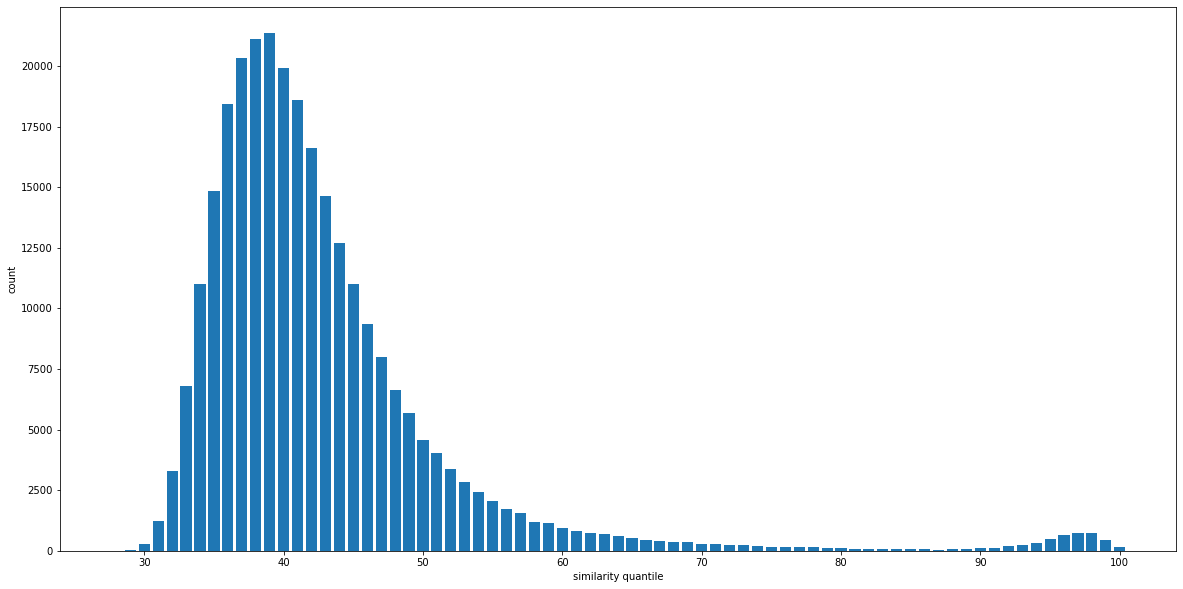

In [150]:
_, ax = plt.subplots(1, 1, figsize=(20, 10))
plt.bar(qcut_count, count)
ax.set_ylabel('count', )
ax.set_xlabel('similarity 0.01 unit')

In [122]:
thres = 0.7
np.where((vals_nl_max > (thres - .05)) & (vals_nl_max < (thres + .05)))

(array([    46,    237,    583, ..., 279254, 279398, 279410]),)

In [96]:
os.path.basename(nonlm_df['filepath'].iloc[0])

'1112fa22c1769d02.jpg'

In [153]:
nonlm_df['image'] = nonlm_df['filepath'].apply(lambda x: os.path.basename(x))

In [155]:
nonlm_df.drop(columns='filepath', inplace=True)

In [159]:
nonlm_df['similarity'] = vals_nl

In [162]:
nonlm_df.to_csv('../scrapped_non_landmark_meta.csv', index=False)

In [133]:
vals_nl[vals_nl > 0.5].shape

(32918,)

similarity: 0.608887


Text(0.5, 1.0, '111f00e827761f47.jpg')

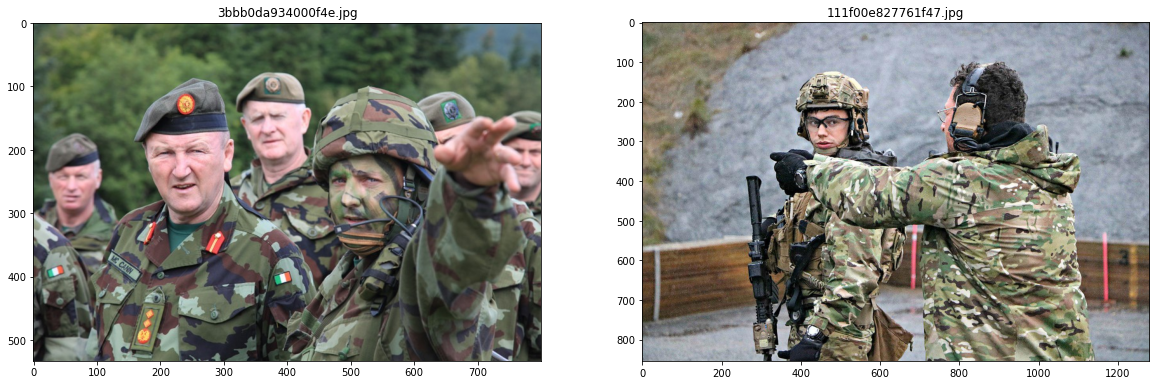

In [125]:
plot_idx = 76
compare_nlm = cv2.imread(nonlm_df['filepath'].iloc[plot_idx])[:,:,::-1]
compare_cln = cv2.imread(df_cln['filepath'].iloc[inds_nl[plot_idx]])[:,:,::-1]
print('similarity: {:.6f}'.format(vals_nl[plot_idx]))
_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(compare_cln)
ax[0].set_title(os.path.basename(df_cln['filepath'].iloc[inds_nl[plot_idx]]))
ax[1].imshow(compare_nlm)
ax[1].set_title(os.path.basename(nonlm_df['filepath'].iloc[plot_idx]))